# Visual proprioception experiments

Experiments whether the robot can recover its own positional parameters from the visual input. This is useful in itself, but it is also a reasonable sanity test of whether the vision system is meaningful.

In [1]:
import sys
sys.path.append("..")
from settings import Config

import pathlib
#from pprint import pformat


import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

from behavior_cloning.demo_to_trainingdata import BCDemonstration
from sensorprocessing import sp_conv_vae
from robot.al5d_position_controller import RobotPosition

exp = Config().get_experiment("proprio_vae_mlp_00")
print(exp)

Loading pointer config file: C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
Loading machine-specific config file: G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml
Configuration for experiment: proprio_vae_mlp_00 successfully loaded
{'proprioception_mlp_model_file': 'proprioception_mlp.pth', 'proprioception_input_file': 'train_inputs.pt', 'proprioception_target_file': 'train_targets.pt', 'proprioception_test_input_file': 'test_inputs.pt', 'proprioception_test_target_file': 'test_targets.pt', 'proprioception_training_task': 'proprioception-cluttered', 'proprioception_testing_task': 'proprioception-uncluttered', 'proprioception_dir': 'c:\\Users\\lboloni\\Documents\\Code\\_TempData\\BerryPicker-experiments\\Proprioception\\proprio_vae_mlp_00'}


## Creating the training and validation data


In [2]:
def load_demonstrations_as_proprioception_training(sp, task, proprioception_input_file, proprioception_output_file):
    """Loads all the images of a task, and processes it as two tensors as input and target data for proprioception training. 
    Caches the processed results into the input and target file pointed in the config. Remove those files to recalculate
    """
    retval = {}
    if proprioception_input_file.exists():
        retval["inputs"] = torch.load(proprioception_input_file, weights_only=True)
        retval["targets"] = torch.load(proprioception_target_file, weights_only=True)
    else:
        demos_dir = pathlib.Path(Config()["demos"]["directory"])
        task_dir = pathlib.Path(demos_dir, "demos", task)
        
        inputlist = []
        targetlist = []

        for demo_dir in task_dir.iterdir():
            if not demo_dir.is_dir():
                pass
            bcd = BCDemonstration(demo_dir, sensorprocessor=sp)
            print(bcd)
            z, a = bcd.read_z_a()
            # normalize the actions
            print(z.shape)
            print(a.shape)
            anorm = np.zeros(a.shape, np.float32)
            for i in range(a.shape[0]):
                rp = RobotPosition.from_vector(a[i])
                anorm[i,:] = rp.to_normalized_vector()        
            # FIXME the repeated name for inputs and targets
            print(z.shape)
            print(anorm.shape)

            for i in range(z.shape[0]):
                inp = torch.from_numpy(z[i])
                tgt = torch.from_numpy(anorm[i])
                inputlist.append(inp)
                targetlist.append(tgt)

        retval["inputs"] = torch.stack(inputlist)
        retval["targets"] = torch.stack(targetlist)
        torch.save(retval["inputs"], proprioception_input_file)
        torch.save(retval["targets"], proprioception_target_file)

    # Separate the training and validation data. 
    # We will be shuffling the demonstrations 
    length = retval["inputs"].size(0)
    rows = torch.randperm(length) 
    shuffled_inputs = retval["inputs"][rows]
    shuffled_targets = retval["targets"][rows]

    training_size = int( length * 0.67 )
    retval["inputs_training"] = shuffled_inputs[1:training_size]
    retval["targets_training"] = shuffled_targets[1:training_size]

    retval["inputs_validation"] = shuffled_inputs[training_size:]
    retval["targets_validation"] = shuffled_targets[training_size:]

    return retval


In [3]:
# Define the MLP regression model
class MLPRegression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
# it seems to work with this one very well...
# task = "proprioception-cluttered"

conv_vae_jsonfile = Config()["controller"]["vae_json"]
conv_vae_resume_model_pthfile = Config()["controller"]["vae_model"]
sp = sp_conv_vae.ConvVaeSensorProcessing(conv_vae_jsonfile, conv_vae_resume_model_pthfile)

task = exp["proprioception_training_task"]
proprioception_input_file = pathlib.Path(exp["proprioception_dir"], 
                                            exp["proprioception_input_file"])
proprioception_target_file = pathlib.Path(exp["proprioception_dir"], 
                                            exp["proprioception_target_file"])
tr = load_demonstrations_as_proprioception_training(sp, task, 
                                                    proprioception_input_file, proprioception_target_file)
inputs_training = tr["inputs_training"]
targets_training = tr["targets_training"]
inputs_validation = tr["inputs_validation"]
targets_validation = tr["targets_validation"]

# Initialize model, loss function, and optimizer
input_size = inputs_training.size(1)
hidden_size = 64
output_size = targets_training.size(1)

print(input_size)
print(output_size)

model = MLPRegression(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\exploratory_experiments\..\sensorprocessing\sp_conv_vae.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.

Cameras found: ['dev2']
There are 650 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']
{'actiontype': 'rc-position-target',
 'camera': 'dev2',
 'cameras': ['dev2'],
 'maxsteps': 650,
 'sensorprocessor': <sensorprocessing.sp_conv_vae.ConvVaeSensorProcessing object at 0x00000231FC7193D0>,
 'source_dir': WindowsPath('C:/Users/lboloni/Documents/Code/_TempData/BerryPicker-demos/demos/proprioception-cluttered/2024_10_26__16_42_34'),
 'trim_from': 1,
 'trim_to': 650}
(649, 128)
(649, 6)
(649, 128)
(649, 6)
Cameras found: ['dev2']
There are 452 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']
{'actiontype': 'rc-position-target',
 'camera': 'dev2',
 'cameras': ['dev2'],
 'maxsteps': 452,
 'sensorprocessor': <sensorprocessing.sp_conv_vae.ConvVaeSensorProcessing object at 0x00000231FC7193D0>,
 'source_dir': WindowsPath('C:/Users/lboloni/Documents/Code/_TempData/BerryPicker-demos/demos/proprioception-clutte

In [5]:
# Create DataLoaders for batching
batch_size = 32
train_dataset = TensorDataset(inputs_training, targets_training)
test_dataset = TensorDataset(inputs_validation, targets_validation)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
def train_and_save_proprioception_model(modelfile, epochs=20):
    """Trains and saves the proprioception model
    FIXME: must have parameters etc to investigate alternative models. 
    """

    # Training loop
    num_epochs = epochs
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            # Forward pass
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')

    # Evaluate the model
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')
    torch.save(model.state_dict(), modelfile)

In [7]:
# modelfile = pathlib.Path(Config()["explorations"]["proprioception_mlp_model_file"])
modelfile = pathlib.Path(exp["proprioception_dir"], 
                         exp["proprioception_mlp_model_file"])
if modelfile.exists():
    model.load_state_dict(torch.load(modelfile))
else:
    train_and_save_proprioception_model(modelfile, epochs=20)

Epoch [10/20], Loss: 0.0185
Epoch [20/20], Loss: 0.0164
Test Loss: 0.0155


In [8]:
# Checking if the reloaded model works
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')
torch.save(model.state_dict(), modelfile)

Test Loss: 0.0155


# Visualize the proprioception
Run the model with the original input.
FIXME: here we need to make a different set of tests

In [9]:
#y = []

task = exp["proprioception_testing_task"]
proprioception_input_file = pathlib.Path(exp["proprioception_dir"], 
                                            exp["proprioception_test_input_file"])
proprioception_target_file = pathlib.Path(exp["proprioception_dir"], 
                                            exp["proprioception_test_target_file"])
tr2 = load_demonstrations_as_proprioception_training(sp, task, 
                                                    proprioception_input_file, proprioception_target_file)


inputs = tr2["inputs"] # these are actually tensors
targets = tr2["targets"]
no_from = 0
no_to = inputs.shape[0]
ypred = []
y = []
t = []
with torch.no_grad():
    for i in range(no_from, no_to):
        x = inputs[i]
        predictions = model(torch.unsqueeze(x, dim=0))
        # append the data 
        t.append(i)
        y.append(targets[i].numpy())
        ypred.append(predictions[0].numpy())

Cameras found: ['dev2']
There are 744 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']
{'actiontype': 'rc-position-target',
 'camera': 'dev2',
 'cameras': ['dev2'],
 'maxsteps': 744,
 'sensorprocessor': <sensorprocessing.sp_conv_vae.ConvVaeSensorProcessing object at 0x00000231FC7193D0>,
 'source_dir': WindowsPath('C:/Users/lboloni/Documents/Code/_TempData/BerryPicker-demos/demos/proprioception-uncluttered/2024_10_26__16_18_47'),
 'trim_from': 1,
 'trim_to': 744}
(743, 128)
(743, 6)
(743, 128)
(743, 6)
Cameras found: ['dev2']
There are 968 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']
{'actiontype': 'rc-position-target',
 'camera': 'dev2',
 'cameras': ['dev2'],
 'maxsteps': 968,
 'sensorprocessor': <sensorprocessing.sp_conv_vae.ConvVaeSensorProcessing object at 0x00000231FC7193D0>,
 'source_dir': WindowsPath('C:/Users/lboloni/Documents/Code/_TempData/BerryPicker-demos/demos/proprioception-uncl

In [10]:
ypred = np.array(ypred)
y = np.array(y)
t = np.array(t)


Create a graph with the six degrees of freedom, predicted and real value

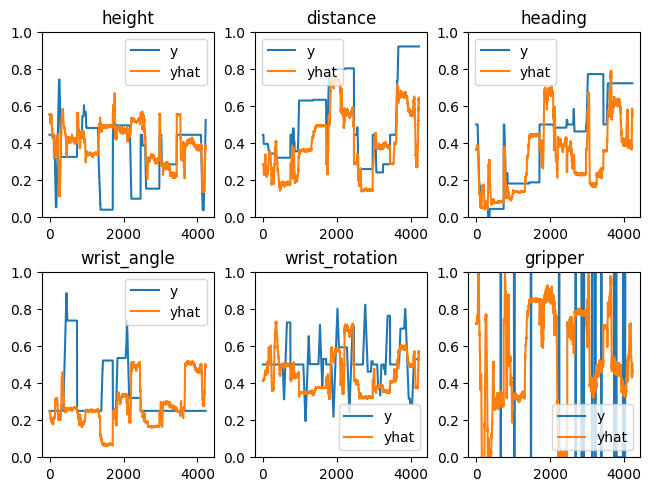

In [14]:
fig, axs = plt.subplots(2,3, constrained_layout=True)
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(6):
    ax = axs[i//3, i%3] 
    ax.set_ylim(0, 1)
    ax.plot(t, y[:,i], label="y")
    ax.plot(t, ypred[:,i], label="yhat")
    ax.legend()
    ax.set_title(titles[i])

graphfilename = pathlib.Path(exp["proprioception_dir"], "proprio_error.pdf")
plt.savefig(graphfilename)
